<a href="https://colab.research.google.com/github/mschoi12/youtube-cnn-002-pytorch-unet/blob/master/Peak_RR_240917.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, savgol_filter
from matplotlib.pyplot import *
from datetime import datetime

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
fp = '/content/drive/MyDrive/Dataset/Apnea/64-231113-KHK.csv'

In [65]:
cap_r = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(2), encoding='utf-8')
cap = np.char.strip(cap_r, '"').astype(int)
capf = savgol_filter(cap, 11, 3)
cap.shape

(117035,)

In [62]:
time_r = np.genfromtxt(fp, delimiter=',', skip_header=1, dtype=None, usecols=(1), encoding='utf-8')
time = [datetime.strptime(t.strip('"').strip("'"), '%Y-%m-%d %H:%M:%S.%f') for t in time_r] # Slice the string to remove the last 5 characters (microseconds except the first digit)
len(time)

117035

### 기존 scipy find_peak 모듈 사용

In [7]:
# 피크 감지 (높이 임계값 조정 가능)
peaks, _ = find_peaks(cap, height=0.3, distance=1)  # 최소 거리 임계값은 필요에 따라 조정

# Convert peaks to a 1D integer array if it's not already
#peaks = peaks.astype(int).flatten()

# 피크 간의 시간 차이 계산 (초 단위로)
peak_times = [time[i].timestamp() for i in peaks]
peak_intervals = np.diff(peak_times)

# 호흡 주기(초당 호흡 수)를 1/peak_intervals로 계산한 후, 분당 호흡수를 얻기 위해 60을 곱함
rr = 60 / peak_intervals
rr = np.append(rr, np.mean(rr))
rr.shape, rr

((32742,),
 array([ 60.        ,  74.99998212, 100.00001589, ..., 100.00001589,
         24.99999901, 102.54780805]))

In [ ]:
rr.shape, peaks.shape, len(peak_times), len(time)

((23765,), (23765,), 23765, 104851)

In [ ]:
rrv = np.diff(rr)

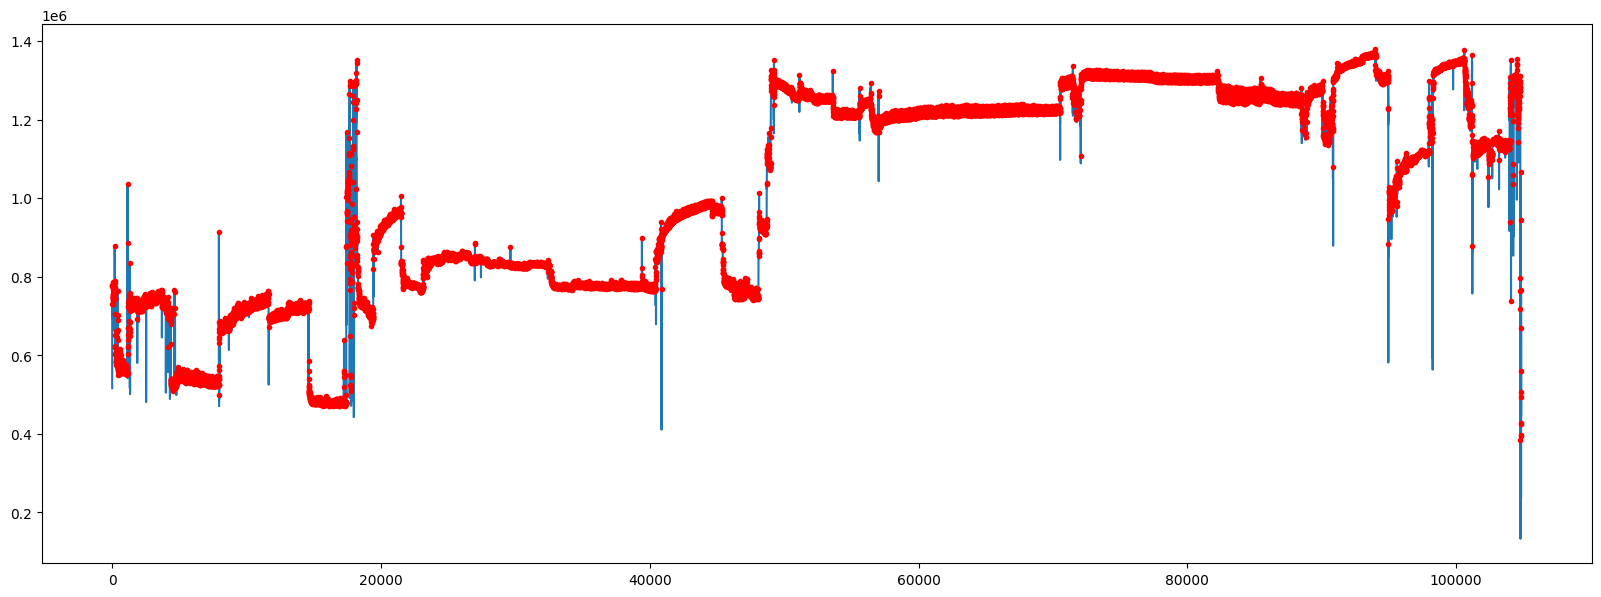

In [ ]:
figure(figsize=(20,7)); plot(cap); plot(peaks, cap[peaks], 'r.'); show();

### Custom Peak Algotithm

In [63]:
def find_peaks_and_valleys(data, window_size):
    # 이동 평균 계산
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    # 상태 변화 감지 (1: rising, -1: falling)
    state = np.sign(np.diff(moving_avg))
    peaks = []
    valleys = []
    # rising에서 falling으로 변화하는 지점에서 peak 찾기
    for i in range(1, len(state)-1):
        if state[i-1] == 1 and state[i] == -1:
            peak_idx = np.argmax(data[i:i+window_size]) + i  # 최대값의 인덱스 찾기
            peaks.append(peak_idx)
        elif state[i-1] == -1 and state[i] == 1:
            valley_idx = np.argmin(data[i:i+window_size]) + i  # 최소값의 인덱스 찾기
            valleys.append(valley_idx)
    return np.array(peaks), np.array(valleys)

def calculate_rr(peaks, time):
    # peak 간의 시간 차이 계산 (초 단위)
    peak_times = [time[i].timestamp() for i in peaks]
    peak_intervals = np.diff(peak_times)
    # 호흡 주기(초당 호흡 수)를 1/peak_intervals로 계산한 후, 분당 호흡수를 얻기 위해 60을 곱함
    rr = 60 / peak_intervals
    return rr

window_size = 10  # 이동 평균 윈도우 크기
# find_peaks_and_valleys 함수를 사용하여 peak과 bottom 찾기
peaks, valleys = find_peaks_and_valleys(capf, window_size)

# calculate_rr 함수를 사용하여 분당 호흡 수 계산
rr = calculate_rr(peaks, time)

# 결과 출력
print("Peaks:", peaks)
print("Valleys:", valleys)
print("Respiratory Rate:", rr)

Peaks: [     4     21     42 ... 116990 117006 117020]
Valleys: [     6     36     52 ... 117000 117012 117024]
Respiratory Rate: [17.64705957 14.28571412 13.04347786 ... 20.         18.74999972
 21.42857179]


<ipython-input-63-3dd77b563f61>:23: RuntimeWarning: divide by zero encountered in divide
  rr = 60 / peak_intervals


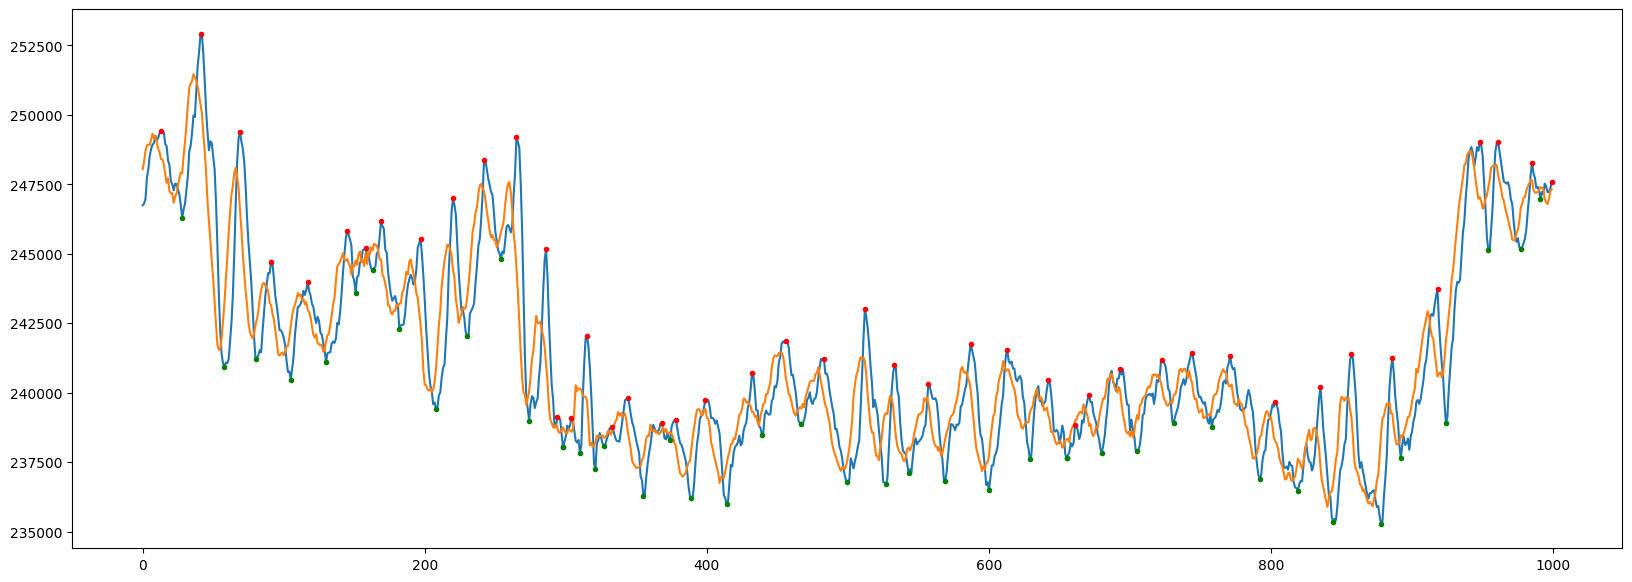

In [66]:
s, e = 22000, s+1000;
peaksl = peaks[(peaks>s) & (peaks<e)]; peaksl_i = peaksl - s
valleysl = valleys[(valleys>s) & (valleys<e)]; valleysl_i = valleysl - s
figure(figsize=(20,7)); plot(capf[s:e]); plot(moving_avg[s:e]); plot(peaksl_i, capf[peaksl], 'r.'); plot(valleysl_i, capf[valleysl], 'g.');

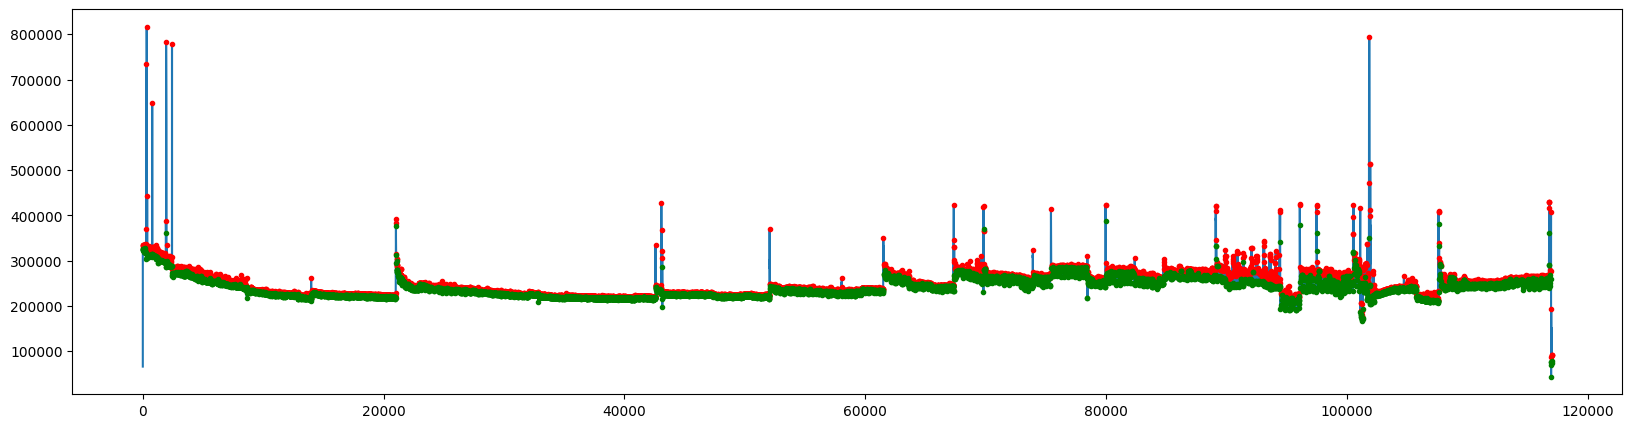

In [51]:
figure(figsize=(20,5)); plot(cap); plot(peaks, cap[peaks], 'r.'); plot(valleys, cap[valleys], 'g.');

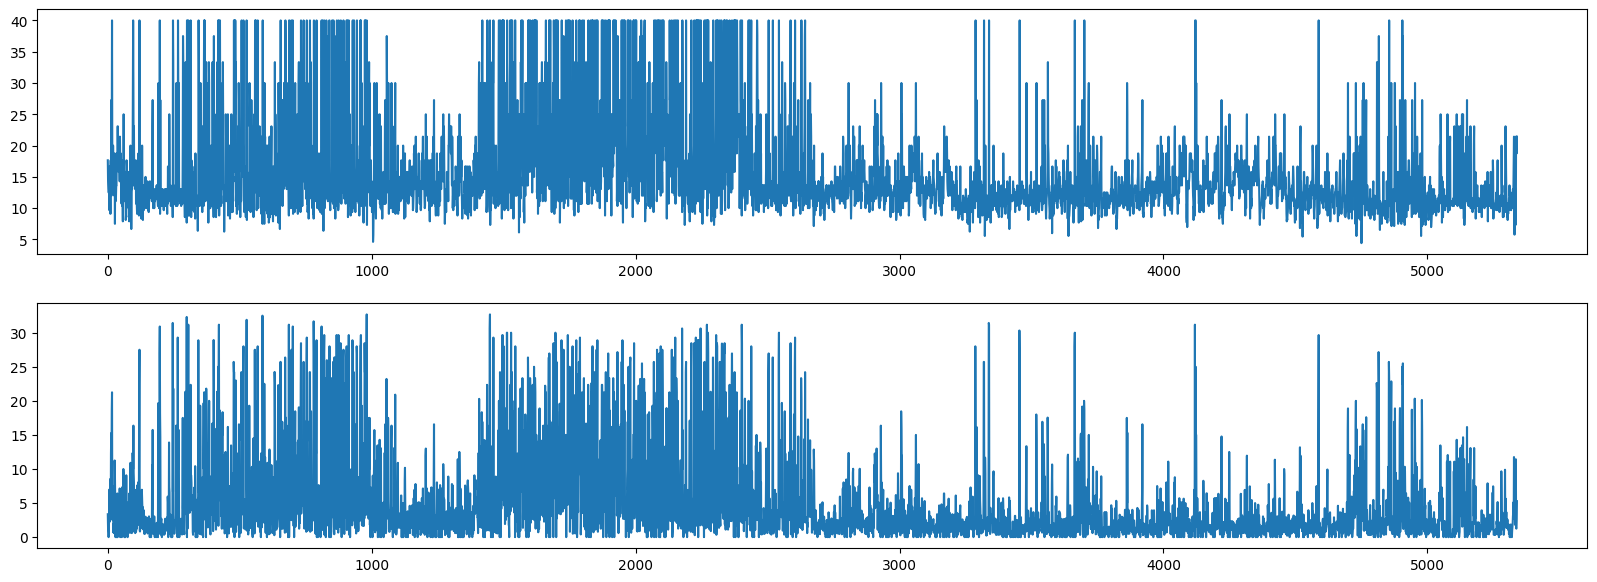

In [69]:
rr[rr>40] = 40; rrv = abs(np.diff(rr)); rrv = np.append(rrv, np.mean(rrv));
figure(figsize=(20,7)); subplot(211); plot(rr); subplot(212); plot(rrv)